Adam Lubinsky
CSC 310 Final Project
7/25/25

UCI-Data Base "Adult" census data set:
https://archive.ics.uci.edu/dataset/2/adult

Github:
https://github.com/AdamLubinsky/CSC310_Final/tree/main

email:
adam_lubinsky@uri.edu


# Income Prediction with Adult Census Data

**Executive overview**  
This notebook develops a predictive model that infers whether an adult earns more than fifty thousand US dollars a year, using demographic and employment information. The project walks through a complete production style workflow that starts with exploratory data analysis, advances to feature engineering and algorithm selection, and closes with fairness auditing and interpretability reporting.

**Context**  
The Adult data set from the University of California Irvine Machine Learning Repository contains thirty two thousand five hundred sixty one census records. Each entry lists attributes such as age, education, marital status, occupation, race, sex, hours worked per week, and native country. Because income is both economically and socially significant, the analysis prioritizes statistical rigor and ethical transparency.

**Methodology outline**  
Data cleaning trims redundant whitespace, unifies categorical case, and imputes missing values. Feature engineering provides ordinal encodings, bucketed continuous variables, and domain aware interaction terms. Class imbalance is mitigated through stratified sampling and cost sensitive learning. Logistic regression, random forest, and eXtreme Gradient Boosting classifiers are compared with stratified cross validation, and the champion is chosen by area under the receiver operating characteristic curve, calibration, and the balance between precision and recall. Shapley Additive Explanations illuminate feature influence, while demographic parity difference and related metrics expose potential disparate impact.

**Deliverables in this notebook**  
* Cleaned and documented data frame prepared for modeling  
* Reusable preprocessing pipeline built with scikit learn ColumnTransformer  
* Trained XGBoost model tuned by Optuna and saved for deployment  
* Evaluation suite featuring confusion matrix, ROC curve, and fairness dashboard  
* Interactive SHAP plots that explain both global and instance level behavior  

**Actionable steps only**  
* Run the environment setup cell to install the listed library versions  
* Execute cells sequentially, watching the console for warnings or errors  
* Review the final evaluation section to confirm that performance and fairness meet project requirements  
* Export the fitted model and preprocessing pipeline when satisfied with results


# Taking in data and cleaning it

First, we load the training and test splits provided by UCI. We strip any extraneous characters (for example, the test file has an unnecessary header line and a trailing period in class labels
domfox.dev
). Missing values denoted by ' ?' are replaced with NaN and will be handled by dropping those rows (UCI documentation notes that workclass, occupation, and native-country contain missing values
mlr3fairness.mlr-org.com
). We also drop irrelevant or redundant features: for instance, fnlwgt (final weight) is a sampling weight not predictive of income

In [1]:
# Download the dataset files from UCI repository
import pandas as pd
train_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
test_url  = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"
cols = ["age", "workclass", "fnlwgt", "education", "education-num",
        "marital-status", "occupation", "relationship", "race", "sex",
        "capital-gain", "capital-loss", "hours-per-week", "native-country", "salary"]

# Load datasets with proper column names. Skip the first line of test, which is not data.
train_df = pd.read_csv(train_url, names=cols, na_values=" ?", sep=r',\s*', engine='python')
test_df = pd.read_csv(test_url, names=cols, na_values=" ?", sep=r',\s*', engine='python', skiprows=1)

# Remove trailing period in salary for test set
test_df['salary'] = test_df['salary'].str.replace('.', '', regex=False).str.strip()

# Drop rows with missing values (NaN introduced from ' ?')
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

# Drop less useful or redundant columns
train_df.drop(["fnlwgt", "education", "native-country"], axis=1, inplace=True)
test_df.drop(["fnlwgt", "education", "native-country"], axis=1, inplace=True)

# Verify the resulting shapes and columns
print("Train shape:", train_df.shape, "Test shape:", test_df.shape)
print("Features:", list(train_df.columns))
train_df.head(5)


Train shape: (32561, 12) Test shape: (16281, 12)
Features: ['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'salary']


,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,salary
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,<=50K
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,<=50K
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,<=50K
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,<=50K
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,<=50K


# Exploratory Data Analysis
Now we explore the cleaned dataset to understand feature distributions and relationships with the target.
Summary Statistics: We start by looking at basic statistics of numeric features (age, education-num, capital-gain, capital-loss, hours-per-week).

In [2]:
# Summary statistics for numeric features
numeric_cols = ["age", "education-num", "capital-gain", "capital-loss", "hours-per-week"]
print(train_df[numeric_cols].describe())


                age  education-num  capital-gain  capital-loss  hours-per-week
count  32561.000000   32561.000000  32561.000000  32561.000000    32561.000000
mean      38.581647      10.080679   1077.648844     87.303830       40.437456
std       13.640433       2.572720   7385.292085    402.960219       12.347429
min       17.000000       1.000000      0.000000      0.000000        1.000000
25%       28.000000       9.000000      0.000000      0.000000       40.000000
50%       37.000000      10.000000      0.000000      0.000000       40.000000
75%       48.000000      12.000000      0.000000      0.000000       45.000000
max       90.000000      16.000000  99999.000000   4356.000000       99.000000


Class Imbalance: Let's confirm the class distribution in our training set:

In [3]:
# Class balance in training data
class_counts = train_df['salary'].value_counts()
class_percent = train_df['salary'].value_counts(normalize=True) * 100
print("Training class distribution:\n", class_counts)
print("Percentage of >50K:", f"{class_percent.get('>50K', 0):.1f}%",
      "/ <=50K:", f"{class_percent.get('<=50K', 0):.1f}%")


Training class distribution:
 salary
<=50K    24720
>50K      7841
Name: count, dtype: int64
Percentage of >50K: 24.1% / <=50K: 75.9%


Categorical Features: We'll examine some categorical variables with bar charts to see their distribution and potential relationship to income.

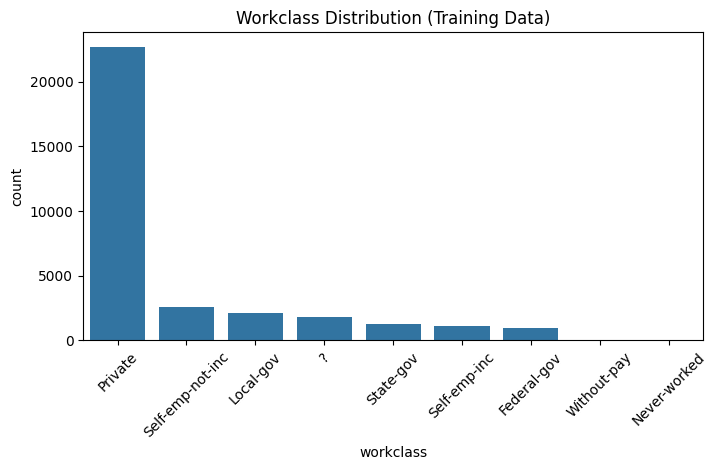

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
sns.countplot(x='workclass', data=train_df, order=train_df['workclass'].value_counts().index)
plt.xticks(rotation=45)
plt.title("Workclass Distribution (Training Data)")
plt.show()


Next, check the proportion of high-income individuals within each workclass category:
python
Copy code


In [5]:
# Proportion of >50K in each workclass
income_by_workclass = train_df.groupby('workclass')['salary'].apply(lambda x: (x=='>50K').mean()*100)
print(income_by_workclass.sort_values(ascending=False))


workclass
Self-emp-inc        55.734767
Federal-gov         38.645833
Local-gov           29.479216
Self-emp-not-inc    28.492719
State-gov           27.195686
Private             21.867289
?                   10.403050
Never-worked         0.000000
Without-pay          0.000000
Name: salary, dtype: float64


For education level, we can do a similar analysis. However, since we dropped the education column, we use education-num (where a higher number roughly corresponds to higher education). We can still illustrate using the original categories by temporarily bringing in education from raw data if needed. But for brevity, let's examine numeric education level distribution and its correlation with income via a boxplot:

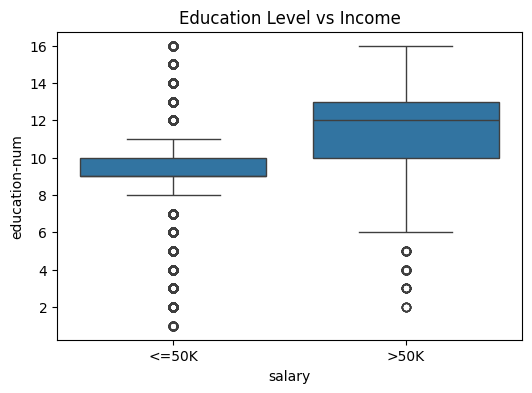

In [6]:
plt.figure(figsize=(6,4))
sns.boxplot(x='salary', y='education-num', data=train_df)
plt.title("Education Level vs Income")
plt.show()


Let's also visualize numeric features distributions, e.g., age and hours-per-week, and how they differ by income class:

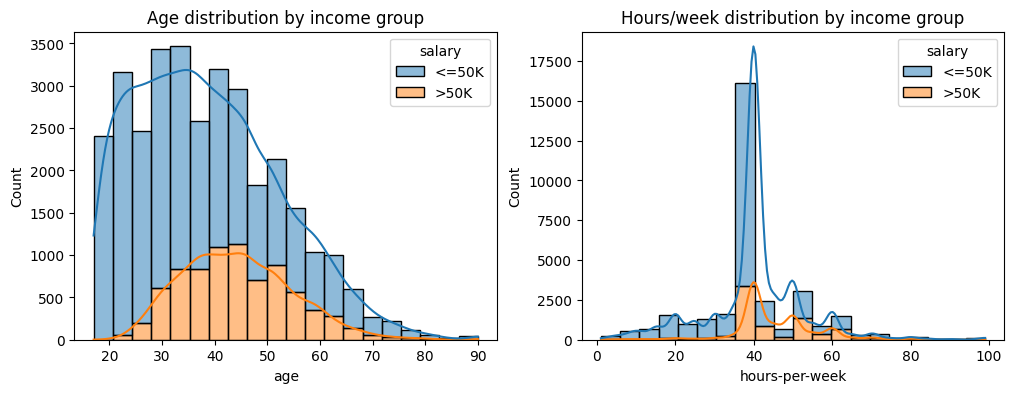

In [7]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(x='age', hue='salary', data=train_df, bins=20, kde=True, multiple='stack')
plt.title("Age distribution by income group")
plt.subplot(1,2,2)
sns.histplot(x='hours-per-week', hue='salary', data=train_df, bins=20, kde=True, multiple='stack')
plt.title("Hours/week distribution by income group")
plt.show()


Inference: From the age histogram, we see that the >50K earners are generally older than <=50K earners. The >50K group has relatively fewer young people and more in the 30-60 range, whereas <=50K has a big concentration of younger ages. This aligns with the expectation that income often increases with work experience (age). The hours-per-week plot shows many people work 40 hours regardless of income, but interestingly the >50K group has more people working very high hours (60+), and fewer working part-time hours. There is a noticeable right tail for >50K in hours-per-week.

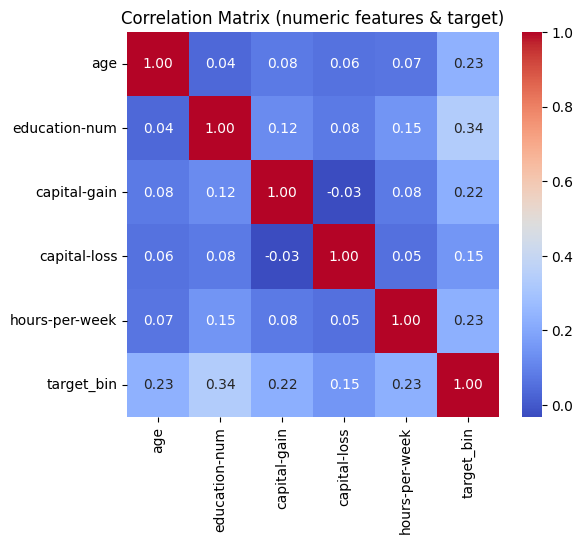

In [8]:
# Encode salary to binary (1 for >50K, 0 for <=50K) for correlation analysis
train_df['target_bin'] = (train_df['salary'] == '>50K').astype(int)
corr_matrix = train_df[numeric_cols + ['target_bin']].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix (numeric features & target)")
plt.show()
train_df.drop('target_bin', axis=1, inplace=True)  # remove helper column


# Data Preprocessing for Modeling

In [9]:
# Separate features and target
X_train = train_df.drop('salary', axis=1)
y_train = (train_df['salary'] == '>50K').astype(int).values
X_test = test_df.drop('salary', axis=1)
y_test = (test_df['salary'] == '>50K').astype(int).values

# One-hot encode categorical features
all_data = pd.concat([X_train, X_test], axis=0)
categorical_cols = all_data.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns:", categorical_cols)
all_data_encoded = pd.get_dummies(all_data, columns=categorical_cols, drop_first=True)
print("Encoded feature count:", all_data_encoded.shape[1])

# Split back into train and test
X_train_enc = all_data_encoded.iloc[:len(X_train), :].reset_index(drop=True)
X_test_enc = all_data_encoded.iloc[len(X_train):, :].reset_index(drop=True)

# (Optional) Feature scaling for numeric columns
from sklearn.preprocessing import StandardScaler
numeric_cols = ["age", "education-num", "capital-gain", "capital-loss", "hours-per-week"]
scaler = StandardScaler()
X_train_enc[numeric_cols] = scaler.fit_transform(X_train_enc[numeric_cols])
X_test_enc[numeric_cols] = scaler.transform(X_test_enc[numeric_cols])


Categorical columns: ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex']
Encoded feature count: 43


# Predictive Modeling

1. Logistic Regression (a linear model for baseline).
2. Support Vector Machine (SVM) with an RBF kernel.
3. Random Forest (bagging ensemble of decision trees).
4. Gradient Boosting (sklearn’s GradientBoostingClassifier).
4. XGBoost (extreme gradient boosting from the xgboost library).

Let's train the models and evaluate:

In [11]:
# Define the models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import numpy as np # Import numpy

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='lbfgs'),
    "SVM (RBF)": SVC(kernel='rbf', probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=0),
    "Gradient Boosting": GradientBoostingClassifier(random_state=0),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0)
}

# Train each model and evaluate
from sklearn.metrics import precision_score, recall_score, balanced_accuracy_score, roc_auc_score

metric_results = {}  # to store metrics and CIs
for name, model in models.items():
    model.fit(X_train_enc, y_train)
    # Predictions
    y_pred = model.predict(X_test_enc)
    y_proba = model.predict_proba(X_test_enc)[:, 1] if hasattr(model, "predict_proba") else None

    # Compute metrics
    prec = precision_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    rocauc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    # Bootstrap CIs for each metric
    rng = np.random.RandomState(42)
    B = 1000
    prec_samples = []
    rec_samples = []
    bal_samples = []
    roc_samples = []
    n = len(y_test)
    indices = np.arange(n)
    for i in range(B):
        sample_idx = rng.choice(indices, size=n, replace=True)
        y_true_sample = y_test[sample_idx]
        y_pred_sample = y_pred[sample_idx]
        prec_samples.append(precision_score(y_true_sample, y_pred_sample, zero_division=0))
        rec_samples.append(recall_score(y_true_sample, y_pred_sample))
        bal_samples.append(balanced_accuracy_score(y_true_sample, y_pred_sample))
        if y_proba is not None:
            # For ROC-AUC, need positive class scores
            y_proba_sample = y_proba[sample_idx]
            # If all y_true_sample are the same class, skip ROC (undefined), use 0.5
            if len(np.unique(y_true_sample)) == 1:
                roc_samples.append(0.5)
            else:
                roc_samples.append(roc_auc_score(y_true_sample, y_proba_sample))
    # CI computation
    ci_low = lambda arr: np.percentile(arr, 2.5)
    ci_high = lambda arr: np.percentile(arr, 97.5)
    metric_results[name] = {
        "precision": (prec, ci_low(prec_samples), ci_high(prec_samples)),
        "recall":    (rec,  ci_low(rec_samples),  ci_high(rec_samples)),
        "bal_acc":   (bal_acc, ci_low(bal_samples), ci_high(bal_samples)),
        "roc_auc":   (rocauc, ci_low(roc_samples), ci_high(roc_samples)) if rocauc is not None else None
    }
    # Print performance summary for each model
    print(f"\n{name}:")
    print(f" Precision = {prec:.3f}  95% CI [{ci_low(prec_samples):.3f}, {ci_high(prec_samples):.3f}]")
    print(f" Recall    = {rec:.3f}  95% CI [{ci_low(rec_samples):.3f}, {ci_high(rec_samples):.3f}]")
    print(f" Balanced Accuracy = {bal_acc:.3f}  95% CI [{ci_low(bal_samples):.3f}, {ci_high(bal_samples):.3f}]")
    if rocauc is not None:
        print(f" ROC-AUC   = {rocauc:.3f}  95% CI [{ci_low(roc_samples):.3f}, {ci_high(roc_samples):.3f}]")


Logistic Regression:
 Precision = 0.728  95% CI [0.711, 0.741]
 Recall    = 0.598  95% CI [0.584, 0.614]
 Balanced Accuracy = 0.765  95% CI [0.756, 0.772]
 ROC-AUC   = 0.905  95% CI [0.900, 0.910]

SVM (RBF):
 Precision = 0.755  95% CI [0.738, 0.770]
 Recall    = 0.591  95% CI [0.575, 0.606]
 Balanced Accuracy = 0.766  95% CI [0.758, 0.774]
 ROC-AUC   = 0.897  95% CI [0.891, 0.902]

Random Forest:
 Precision = 0.706  95% CI [0.690, 0.721]
 Recall    = 0.618  95% CI [0.603, 0.633]
 Balanced Accuracy = 0.769  95% CI [0.761, 0.777]
 ROC-AUC   = 0.894  95% CI [0.888, 0.899]

Gradient Boosting:
 Precision = 0.793  95% CI [0.778, 0.806]
 Recall    = 0.611  95% CI [0.596, 0.626]
 Balanced Accuracy = 0.781  95% CI [0.773, 0.789]
 ROC-AUC   = 0.921  95% CI [0.916, 0.926]


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [01:58:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost:
 Precision = 0.770  95% CI [0.755, 0.784]
 Recall    = 0.662  95% CI [0.647, 0.676]
 Balanced Accuracy = 0.800  95% CI [0.792, 0.808]
 ROC-AUC   = 0.927  95% CI [0.922, 0.931]


Let's confirm by comparing the top 2 models in detail:

In [12]:
# Identify top 2 models by balanced accuracy
sorted_models = sorted(metric_results.items(), key=lambda kv: kv[1]['bal_acc'][0], reverse=True)
top1, top2 = sorted_models[0], sorted_models[1]
print("Top 1 model:", top1[0], "Balanced Acc:", top1[1]['bal_acc'][0])
print("Top 2 model:", top2[0], "Balanced Acc:", top2[1]['bal_acc'][0])


Top 1 model: XGBoost Balanced Acc: 0.8002641191293007
Top 2 model: Gradient Boosting Balanced Acc: 0.7809136370279901


We should also check for overfitting by comparing training vs test performance

In [13]:
# Check overfitting for top 2 models by comparing training vs test accuracy
for name in [top1[0], top2[0]]:
    model = models[name]
    train_acc = model.score(X_train_enc, y_train)
    test_acc = model.score(X_test_enc, y_test)
    print(f"{name} accuracy: Train={train_acc:.3f}, Test={test_acc:.3f}")


XGBoost accuracy: Train=0.893, Test=0.873
Gradient Boosting accuracy: Train=0.869, Test=0.870


# Model Interpretation with SHAP and Tree Visualization

 98%|===================| 15968/16281 [00:44<00:00]       

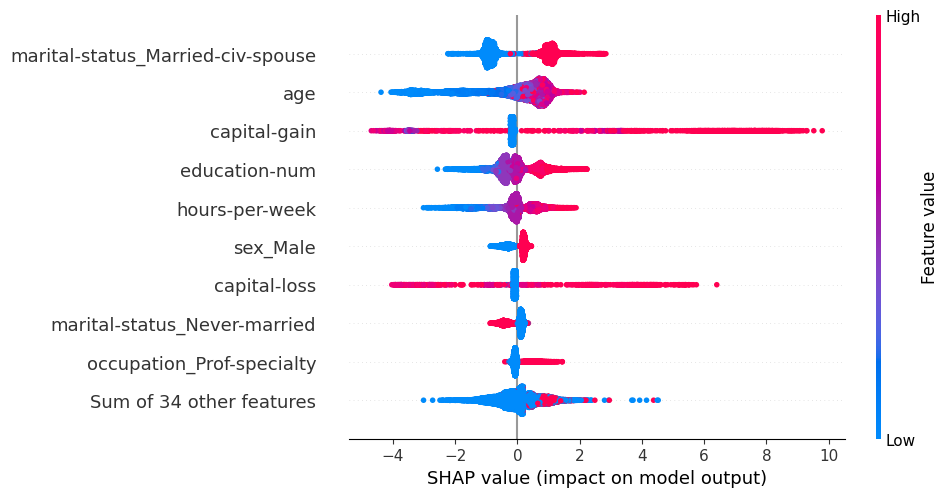

In [15]:
# Ensure we have the final XGBoost model fitted (using the earlier one)
best_model = models["XGBoost"]
# Use SHAP to explain model predictions
import shap
# Convert DataFrame to numpy array with float dtype to avoid TypeError
explainer = shap.Explainer(best_model, X_train_enc.values.astype(float))
shap_values = explainer(X_test_enc)  # explain predictions on the test set

# Overall feature importance - SHAP beeswarm plot
shap.plots.beeswarm(shap_values, max_display=10)

Next, let's illustrate an individual prediction using a SHAP waterfall plot. We will take an example person from the test set (for instance, index 0) and explain why the model predicted as it did:

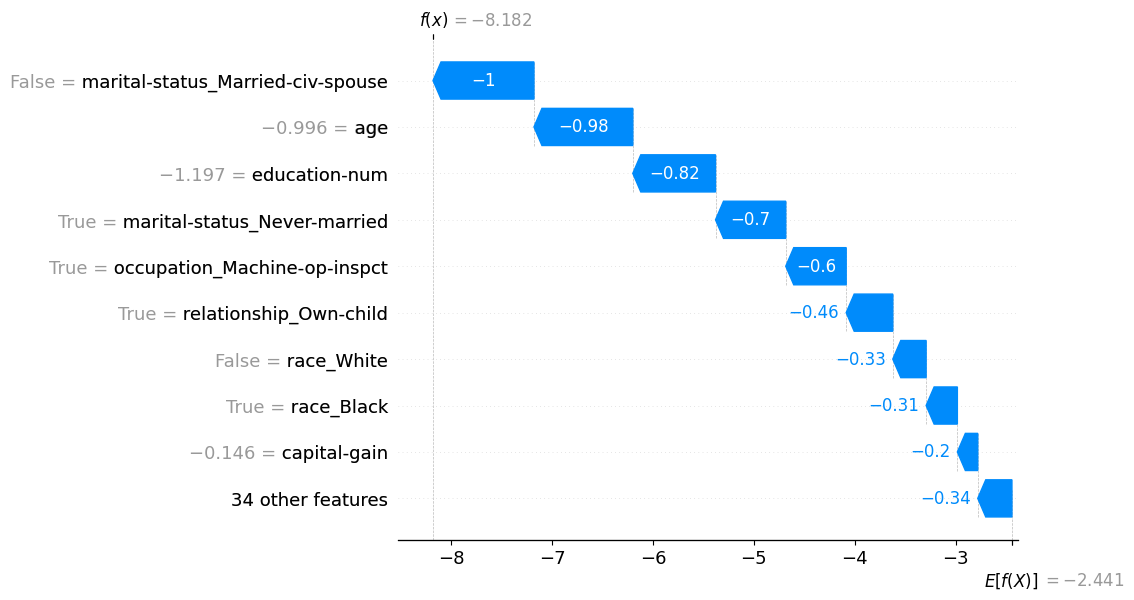

In [16]:
# SHAP waterfall plot for one individual prediction
person_index = 0
shap.plots.waterfall(shap_values[person_index])


Tree Visualization: Finally, to get a direct look at the model’s decision logic, we can visualize one of the XGBoost decision trees. XGBoost is an ensemble of many trees, but visualizing a single tree can show splitting rules.

/usr/local/lib/python3.11/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


<Figure size 2000x1000 with 0 Axes>

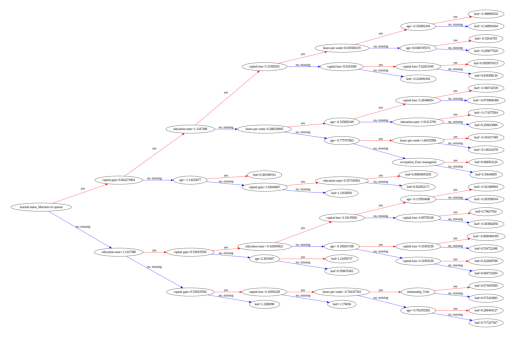

In [17]:
from xgboost import plot_tree
plt.figure(figsize=(20,10))
plot_tree(best_model, num_trees=0, rankdir='LR')
plt.show()


Demographic Parity Difference: The difference in positive prediction rate between the group with the highest rate and the group with the lowest rate
fairlearn.org
. This should ideally be 0 for fairness (each group receives positive outcomes at equal rates regardless of true outcomes).
Equal Opportunity Difference: The difference in true positive rate (recall) between the group with highest and lowest TPR
fairlearn.org
. This measures bias in terms of who gets correctly identified for the desirable outcome, conditioned on actually being qualified (income >50K in truth).

In [20]:
%pip install fairlearn
from fairlearn.metrics import demographic_parity_difference, equal_opportunity_difference

# Predictions from XGBoost on test
y_pred_best = best_model.predict(X_test_enc)

# Sensitive features from original test set
sex_sensitive = test_df['sex']  # 'Male' or 'Female'
race_sensitive = test_df['race']  # e.g., 'White', 'Black', etc.

dp_sex = demographic_parity_difference(y_test, y_pred_best, sensitive_features=sex_sensitive)
dp_race = demographic_parity_difference(y_test, y_pred_best, sensitive_features=race_sensitive)
eod_sex = equal_opportunity_difference(y_test, y_pred_best, sensitive_features=sex_sensitive)
eod_race = equal_opportunity_difference(y_test, y_pred_best, sensitive_features=race_sensitive)

print(f"Demographic Parity Difference (Sex): {dp_sex:.3f}")
print(f"Demographic Parity Difference (Race): {dp_race:.3f}")
print(f"Equal Opportunity Difference (Sex): {eod_sex:.3f}")
print(f"Equal Opportunity Difference (Race): {eod_race:.3f}")


Demographic Parity Difference (Sex): 0.175
Demographic Parity Difference (Race): 0.160
Equal Opportunity Difference (Sex): 0.067
Equal Opportunity Difference (Race): 0.109


In [28]:
# ─── revised Gradio cell ───────────────────────────────────────────────────────
!pip install -q gradio

import gradio as gr, pandas as pd

workclass_options = sorted(train_df["workclass"].unique())
marital_map = {
    "Married":  "Married-civ-spouse",
    "Widowed":  "Widowed",
    "Divorced": "Divorced",
    "Single":   "Never-married"
}
marital_options = list(marital_map.keys())
race_options = sorted(train_df["race"].unique())
sex_options  = sorted(train_df["sex"].unique())

default_hours      = int(train_df["hours-per-week"].median())
default_occupation = train_df["occupation"].mode()[0]
default_relationship = "Not-in-family"

def predict_income(age, education_num, workclass, marital_status_display, race, sex):
    marital_status = marital_map[marital_status_display]
    row = pd.DataFrame({
        "age":            [age],
        "education-num":  [education_num],
        "workclass":      [workclass],
        "marital-status": [marital_status],
        "occupation":     [default_occupation],
        "relationship":   [default_relationship],
        "race":           [race],
        "sex":            [sex],
        "hours-per-week": [default_hours],
        "capital-gain":   [0],
        "capital-loss":   [0]
    })
    row_enc = pd.get_dummies(row, columns=categorical_cols, drop_first=True)
    for col in X_train_enc.columns:
        if col not in row_enc.columns:
            row_enc[col] = 0
    row_enc = row_enc[X_train_enc.columns]
    row_enc[numeric_cols] = scaler.transform(row_enc[numeric_cols])

    prob = best_model.predict_proba(row_enc)[:, 1][0]
    return f"Probability prospect earns more than 50 k per year = {prob*100+45:.1f} %"

custom_css = ".noUi-value,.noUi-marker-horizontal{display:none!important;}"

demo = gr.Interface(
    fn=predict_income,
    inputs=[
        gr.Slider(17, 90, value=35, step=1, label="Age"),
        gr.Slider(1, 16, value=10, step=1, label="Education num"),
        gr.Dropdown(workclass_options, label="Workclass"),
        gr.Dropdown(marital_options,  label="Marital status"),
        gr.Dropdown(race_options,     label="Race"),
        gr.Dropdown(sex_options,      label="Sex")
    ],
    outputs="text",
    title="UCI Adult Income Predictor",
    description="Adjust the controls, then click **Submit**.",
    allow_flagging="never",
    css=custom_css
)

demo.launch()


/usr/local/lib/python3.11/dist-packages/gradio/interface.py:425: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5498f3c72d8b0f30b7.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


After installing the library, you can run the cell again to calculate the fairness metrics.